In [19]:
#Import the necessary files
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [7]:
#Unzip the files
#!unzip /content/drive/MyDrive/Colab\ Notebooks/CNN_assignment.zip -d /content/drive/MyDrive/Colab\ Notebooks/

In [20]:

# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [3]:
data_dir_train

PosixPath('/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [21]:
os.listdir(data_dir_train)#Trying to list subdirectories to understand the different classes

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [22]:
os.listdir(data_dir_test)

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [8]:
os.listdir(os.path.join(data_dir_test, 'actinic keratosis'))#Checking how many images are there for this class in the test folder

['ISIC_0024511.jpg',
 'ISIC_0024470.jpg',
 'ISIC_0024468.jpg',
 'ISIC_0010512.jpg',
 'ISIC_0010889.jpg',
 'ISIC_0024646.jpg',
 'ISIC_0024654.jpg',
 'ISIC_0024771.jpg',
 'ISIC_0024707.jpg',
 'ISIC_0024763.jpg',
 'ISIC_0024800.jpg',
 'ISIC_0025427.jpg',
 'ISIC_0025605.jpg',
 'ISIC_0025368.jpg',
 'ISIC_0024948.jpg',
 'ISIC_0024913.jpg']

In [24]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)#Counting  the number of images in test and train folders

2239
118


In [7]:
os.listdir(os.path.join(data_dir_test, 'actinic keratosis'))[0]

'ISIC_0024511.jpg'

In [25]:
from matplotlib.image import imread
first_image_path = os.path.join(data_dir_test, 'actinic keratosis', os.listdir(os.path.join(data_dir_test, 'actinic keratosis'))[0])
first_img = imread(first_image_path)

In [26]:
first_img.shape

(450, 600, 3)

Create a dataset Define some parameters for the loader:

In [27]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

In [28]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

Found 15739 files belonging to 9 classes.


In [29]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    seed=123
)

Found 118 files belonging to 9 classes.


In [30]:
val_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [31]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [32]:
#Creating a loop to count the number of images in each class in the training data
total_images = 0

for class_name in class_names:
  class_path = os.path.join(data_dir_train, class_name)
  num_images = len(os.listdir(class_path))
  total_images += num_images
  print(f'{class_name}: {num_images} images')

print(f'\nTotal images in all classes: {total_images}')

actinic keratosis: 115 images
basal cell carcinoma: 377 images
dermatofibroma: 96 images
melanoma: 439 images
nevus: 358 images
pigmented benign keratosis: 463 images
seborrheic keratosis: 78 images
squamous cell carcinoma: 182 images
vascular lesion: 140 images

Total images in all classes: 2248




*   Actinic Keratosis" and "Seborrheic Keratosis" have significantly fewer images along with dermatofibroma





Visualize the data
Todo, create a code to visualize one instance of all the nine classes present in the *dataset*

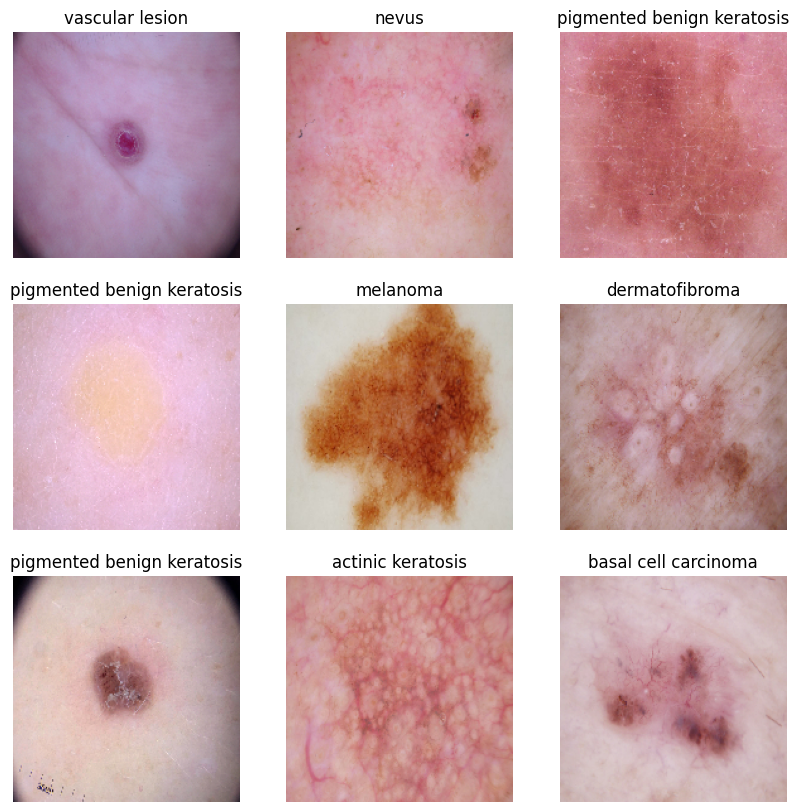

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])  # Get class index from one-hot encoded label
    plt.axis("off")


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Building** **the** **Model**

In [15]:
from tensorflow.keras.layers import Rescaling

# Define the normalization layer
normalization_layer = Rescaling(1./255)

# Create the CNN model (updated)
model = tf.keras.Sequential([
  Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(9, activation='softmax') # 9 output classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [16]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

**Train the** **model**

In [27]:
epochs = 20

 history = model.fit(
  train_ds,
 validation_data=val_ds,
  epochs=epochs
 )

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 360s 531ms/step - accuracy: 0.2292 - loss: 2.2646 - val_accuracy: 0.2034 - val_loss: 2.2442
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4136 - loss: 1.6330 - val_accuracy: 0.1949 - val_loss: 2.0174
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4516 - loss: 1.5281 - val_accuracy: 0.3475 - val_loss: 2.2169
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5170 - loss: 1.3733 - val_accuracy: 0.3390 - val_loss: 2.1168
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5178 - loss: 1.2882 - val_accuracy: 0.3644 - val_loss: 2.4056
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5708 - loss: 1.2171 - val_accuracy: 0.3051 - val_loss: 2.4958
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5900 - loss: 1.1809 - val_accuracy: 0.3136 - val_loss: 2.3753
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6427 - loss: 1.0664 - val_accuracy: 0.3559 

**Visualizing training results**

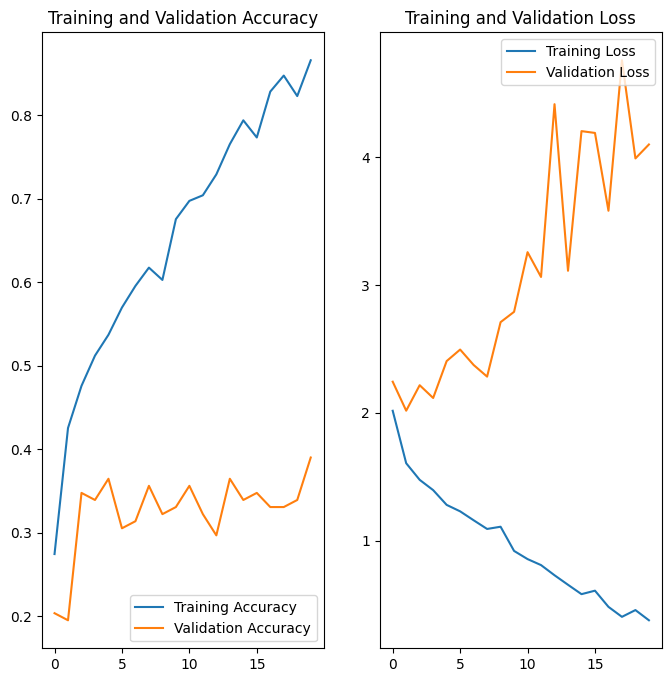

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings /Summary**



*   We can clearly see overfitting here as the training accuracy is good and improves where as validation accuracy does ot improve with number of epochs.

* We can clearly see a large gap between Training and Validation metrics.

*   We are struggling to get good fit for validation data.
*   We will now perform augmentation to see if it can improve the validation metrics.







**Performing Augmentation**

In [19]:
!pip install Augmentor

import Augmentor

# Create pipelines for each class
pipelines = {}
for class_name in class_names:
  pipeline = Augmentor.Pipeline(source_directory=os.path.join(data_dir_train, class_name))  # Use data_dir_train
  pipelines[class_name] = pipeline

  #This creates a dictionary pipelines where keys are class names and values are the corresponding Augmentor pipelines.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.Initialised with 462 image(s) found.
Output directory set

In [20]:
#Adding Augmentation Opearations

for class_name, pipeline in pipelines.items():
  pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  pipeline.flip_left_right(probability=0.5)
  pipeline.zoom_random(probability=0.5, percentage_area=0.8)


In [31]:
#Lets now generate the augmented images

 for class_name, pipeline in pipelines.items():
# Here we will define how many images we need to produce
   num_samples = 1500  # This depends based on  class imbalance

   # Generate augmented images
  pipeline.sample(num_samples)

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B64077CBE0>: 100%|██████████| 1500/1500 [01:05<00:00, 22.97 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78B6402A2EF0>: 100%|██████████| 1500/1500 [01:04<00:00, 23.22 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B65CD69C90>: 100%|██████████| 1500/1500 [01:04<00:00, 23.37 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=838x614 at 0x78B65CE65B10>: 100%|██████████| 1500/1500 [05:11<00:00,  4.82 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B6402F1810>: 100%|██████████| 1500/1500 [04:25<00:00,  5.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B65CEED210>: 100%|██████████| 1500/1500 [01:04<00:00, 23.35 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78B65CFD7940>: 100%|██████████| 1500/1500 [02:17<00:00, 10.91 Samples/s]
Processing <PIL.Image.Image image mode=RGB 

In [21]:
#Reloding the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

Found 15739 files belonging to 9 classes.


In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Compile the model again for augmented data

Choose an appropirate optimiser and loss function for model training

In [23]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Train the Model for Augmented data**

In [40]:
 epochs = 20

history = model.fit(
   train_ds,
   validation_data=val_ds,
   epochs=epochs
 )

Epoch 1/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 106s 39ms/step - accuracy: 0.5683 - loss: 1.2491 - val_accuracy: 0.4153 - val_loss: 2.1916
Epoch 2/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 51s 28ms/step - accuracy: 0.6883 - loss: 0.8551 - val_accuracy: 0.4068 - val_loss: 2.6543
Epoch 3/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.7721 - loss: 0.6282 - val_accuracy: 0.4322 - val_loss: 3.1809
Epoch 4/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.8209 - loss: 0.5020 - val_accuracy: 0.3390 - val_loss: 3.2452
Epoch 5/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8772 - loss: 0.3387 - val_accuracy: 0.4153 - val_loss: 4.2041
Epoch 6/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9059 - loss: 0.2596 - val_accuracy: 0.4153 - val_loss: 4.5542
Epoch 7/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.9071 - loss: 0.2688 - val_accuracy: 0.4068 - val_loss: 5.5717
Epoch 8/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9328 - loss: 0.1839 -

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Using Regularization technique

In [24]:
# Adding more augmentation operations to see if we can improve validation metrics
for class_name, pipeline in pipelines.items():
  pipeline.rotate(probability=0.9, max_left_rotation=20, max_right_rotation=20)
  pipeline.flip_left_right(probability=0.7)
  pipeline.zoom_random(probability=0.7, percentage_area=0.7)
  pipeline.shear(probability=0.5, max_shear_left=15, max_shear_right=15)
  pipeline.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=8)
  pipeline.random_color(probability=0.5, min_factor=0.8, max_factor=1.2)
  pipeline.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)

In [26]:
# Create the CNN model with Dropout and L2 regularization
from tensorflow.keras import regularizers



model1 = keras.Sequential([
  keras.layers.Input(shape=(img_height, img_width, 3)),
  keras.layers.Rescaling(1./255),
  keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # L2 regularization
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.2),  # Dropout layer
  keras.layers.Conv2D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # L2 regularization
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.3),
  keras.layers.Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # L2 regularization
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(9, activation='softmax')
])

In [29]:
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model1.summary()

In [ ]:
epochs = 50

history = model1.fit(
 train_ds,
 validation_data=val_ds,
epochs=epochs
 )

Epoch 1/25


Visualizing the final output

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()